### File pop_general.shp tidak disertakan karena ukuran yang terlalu besar, namun dapat diunduh pada https://data.humdata.org/dataset/worldpop-population-density-for-indonesia

# Instalasi package

In [ ]:
#!pip install geemap
#!pip install pandas
#!pip install geopandas
#!pip install scikit-learn
#!pip install pykrige

In [3]:
import geopandas as gpd

# Download data remote-sensing

In [3]:
import ee
import geemap
import os

In [4]:
ee.initialize()

In [5]:
depok_grid_intersec = geemap.shp_to_ee('depok_grid_intersection.shp')

# LST

In [13]:
LST_2021 = ee.ImageCollection("MODIS/006/MOD11A1").filterDate('2021-01-01', '2021-12-31').filterBounds(depok_grid_intersec)
LST_2021 = LST_2021.reduce(ee.Reducer.median())

# CO

In [15]:
CO = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_CO').select('CO_column_number_density').filterDate('2021-01-01', '2021-12-31')
CO = CO.reduce(ee.Reducer.median())

# NDVI & NDBI

In [4]:
def maskS2clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)

In [5]:
s2021 = ee.ImageCollection('COPERNICUS/S2_SR').filterDate('2021-01-01', '2021-12-31').sort('CLOUD_COVER')

In [6]:
s2021_median = s2021.map(maskS2clouds).reduce(ee.Reducer.median())
s2_composite = s2021_median.addBands(s2021_median.normalizedDifference(['B11_median', 'B8_median']).rename('NDBI'))
s2_composite_ndvi = s2021_median.addBands(s2021_median.normalizedDifference(['B8_median', 'B4_median']).rename('NDVI'))

# Melakukan perhitungan zonal statistics

In [ ]:
geemap.zonal_statistics(LST_2021, depok_grid_intersec, 'lst_intersect', statistics_type='MEDIAN', scale=1000)
geemap.zonal_statistics(CO, depok_grid_intersec, 'co_intersect', statistics_type='MEDIAN', scale=1000)
geemap.zonal_statistics(s2_composite, depok_grid_intersec, 'ndbi_intersect', statistics_type='MEDIAN', scale=1000)
geemap.zonal_statistics(s2_composite_ndvi, depok_grid_intersec, 'ndvi_intersect', statistics_type='MEDIAN', scale=1000)

### Data yang sudah diunduh kemudian digabungkan dengan data grid menggunakan aplikasi QGIS

# Modeling

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pop = gpd.read_file('pop_general.shp')
grid_intersec = gpd.read_file('depok_grid_intersection.shp')

In [3]:
grid_ndvi = pd.read_csv('ndvi_intersec.csv')
grid_ndbi = pd.read_csv('ndbi_intersec.csv')
grid_lst = pd.read_csv('lst_intersec.csv')
grid_co = pd.read_csv('co_intersec.csv')

In [5]:
grid_intersec.loc[:, 'id'] = grid_intersec.id.astype('int64')
grid_intersec.loc[:, 'iddesa'] = grid_intersec.iddesa.astype('int64')

C:\Users\User\AppData\Local\Temp\ipykernel_7896\2991851274.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  grid_intersec.loc[:, 'id'] = grid_intersec.id.astype('int64')
C:\Users\User\AppData\Local\Temp\ipykernel_7896\2991851274.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  grid_intersec.loc[:, 'iddesa'] = grid_intersec.iddesa.astype('int64')


In [8]:
rs_data = grid_ndbi.merge(grid_ndvi, on=['id','iddesa']).merge(grid_lst, on=['id','iddesa']).merge(grid_co, on=['id','iddesa'])
grid_data = grid_intersec.merge(rs_data, on=['id','iddesa'])

In [10]:
pop_join = pop.sjoin(grid_data)

In [11]:
pop_join = pop_join.rename(columns={'idn_genera': 'pop'})

In [12]:
grid_pop = pop_join.groupby(['id', 'iddesa'], as_index=False)['pop'].sum()
desa_pop = pop_join.groupby('iddesa', as_index=False)['pop'].sum()

In [13]:
grid_data = grid_data.merge(grid_pop, on=['id','iddesa'], how='left')
grid_data = grid_data.rename(columns={'pop':'grid_pop'})
grid_data = grid_data.merge(desa_pop, on=['iddesa'], how='left')
grid_data = grid_data.rename(columns={'pop':'desa_pop'})

In [14]:
grid_data.loc[:, 'weighted_kasus'] = grid_data.jmlkasus * grid_data.grid_pop / grid_data.desa_pop

In [15]:
grid_data.loc[:,'centroid'] = grid_data.centroid

C:\Users\User\AppData\Local\Temp\ipykernel_7896\603558672.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_data.loc[:,'centroid'] = grid_data.centroid


In [78]:
# grid_data[(grid_data.weighted_kasus!=0) & ~grid_data.weighted_kasus.isna()].drop(columns='geometry').rename(columns={'centroid': 'geometry'}).to_file('centroid.shp')
# grid_data.drop(columns='geometry').rename(columns={'centroid': 'geometry'}).to_file('centroid_with_null.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_24568\3686103918.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid_data.drop(columns='geometry').rename(columns={'centroid': 'geometry'}).to_file('centroid_with_null.shp')


In [23]:
grid_data = grid_data[['id', 'iddesa', 'centroid', 'jmlkasus', 'NDBI', 'NDVI', 'median', 'LST_Day_1km_median', 'grid_pop', 'Luas']]
grid_data = grid_data.rename(columns={'median': 'CO', 'LST_Day_1km_median': 'LST'})

In [254]:
grid_intersec

,id,iddesa,nmprov,nmkab,nmkec,nmdesa,kdprov,kdkab,kdkec,kddesa,jmlkasus,Luas,new_id,geometry
0,6,3276011006,JAWA BARAT,DEPOK,BOJONGSARI,PONDOK PETIR,32,76,011,006,5,0.676,32760110066,"POLYGON ((106.72586 -6.36868, 106.71736 -6.368..."
1,7,3276011006,JAWA BARAT,DEPOK,BOJONGSARI,PONDOK PETIR,32,76,011,006,5,0.630,32760110067,"POLYGON ((106.72586 -6.36868, 106.72587 -6.377..."
2,8,3276011005,JAWA BARAT,DEPOK,BOJONGSARI,CURUG,32,76,011,005,11,0.314,32760110058,"POLYGON ((106.72587 -6.38542, 106.72570 -6.385..."
3,8,3276011006,JAWA BARAT,DEPOK,BOJONGSARI,PONDOK PETIR,32,76,011,006,5,0.050,32760110068,"POLYGON ((106.72587 -6.37772, 106.72587 -6.379..."
4,9,3276011005,JAWA BARAT,DEPOK,BOJONGSARI,CURUG,32,76,011,005,11,0.001,32760110059,"MULTIPOLYGON (((106.72352 -6.38677, 106.72352 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,368,3276041004,JAWA BARAT,DEPOK,TAPOS,LEUWINANGGUNG,32,76,041,004,5,0.907,3276041004368,"POLYGON ((106.91572 -6.40473, 106.91572 -6.406..."
580,369,3276041004,JAWA BARAT,DEPOK,TAPOS,LEUWINANGGUNG,32,76,041,004,5,0.031,3276041004369,"MULTIPOLYGON (((106.90843 -6.41378, 106.90836 ..."
581,383,3276041004,JAWA BARAT,DEPOK,TAPOS,LEUWINANGGUNG,32,76,041,004,5,0.010,3276041004383,"MULTIPOLYGON (((106.91845 -6.39569, 106.91851 ..."
582,384,3276041004,JAWA BARAT,DEPOK,TAPOS,LEUWINANGGUNG,32,76,041,004,5,0.156,3276041004384,"POLYGON ((106.91844 -6.39569, 106.91845 -6.395..."


In [247]:
# sample.groupby('iddesa', as_index=False)['SAMPLE_1', 'SAMPLE_1_2'].sum().to_csv('sampling.csv', index=False)

In [ ]:
sample = gpd.read_file('sampled_kriging.shp')

,id,iddesa,weighted_k,SAMPLE_1,SAMPLE_1_2,new_id,geometry
0,6,3276011006,0.712565,1.235972,0.663009,32760110066,POINT (106.72228 -6.36509)
1,7,3276011006,0.550910,1.327928,0.632254,32760110067,POINT (106.72258 -6.37225)
2,8,3276011005,0.662981,1.334879,0.724149,32760110058,POINT (106.72400 -6.38271)
3,8,3276011006,0.096099,1.339687,0.621471,32760110068,POINT (106.72444 -6.37839)
4,9,3276011005,NaN,1.327654,0.768260,32760110059,POINT (106.72346 -6.38682)
...,...,...,...,...,...,...,...
579,368,3276041004,0.552347,-1.917732,0.490959,3276041004368,POINT (106.91115 -6.40890)
580,369,3276041004,NaN,-1.597839,0.393897,3276041004369,POINT (106.91030 -6.41437)
581,383,3276041004,0.013165,-2.847114,0.177682,3276041004383,POINT (106.91668 -6.39550)
582,384,3276041004,0.110317,-2.765032,0.208033,3276041004384,POINT (106.91674 -6.39898)


In [248]:
sample = sample.merge(grid_data, on=['id', 'iddesa'])

In [249]:
sample.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 584 entries, 0 to 583
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          584 non-null    int64   
 1   iddesa      584 non-null    int64   
 2   weighted_k  554 non-null    float64 
 3   SAMPLE_1    584 non-null    float64 
 4   SAMPLE_1_2  584 non-null    float64 
 5   new_id      584 non-null    object  
 6   geometry    584 non-null    geometry
 7   centroid    584 non-null    geometry
 8   jmlkasus    584 non-null    int64   
 9   NDBI        545 non-null    float64 
 10  NDVI        545 non-null    float64 
 11  CO          545 non-null    float64 
 12  LST         545 non-null    float64 
 13  grid_pop    554 non-null    float64 
 14  Luas        584 non-null    float64 
dtypes: float64(9), geometry(2), int64(3), object(1)
memory usage: 73.0+ KB


# Transformasi Yeo-Johnson

In [35]:
from sklearn.preprocessing import PowerTransformer
ptscaler = PowerTransformer(method='yeo-johnson')

In [52]:
scaled_sample = sample.copy(deep=True)
scaled_sample.iloc[:, -6:] = ptscaler.fit_transform(scaled_sample.iloc[:, -6:])

In [53]:
scaled_sample

,id,iddesa,weighted_k,SAMPLE_1,SAMPLE_1_2,new_id,geometry,centroid,jmlkasus,NDBI,NDVI,CO,LST,grid_pop,Luas
0,6,3276011006,0.712565,1.235972,0.663009,32760110066,POINT (106.72228 -6.36509),POINT (106.72228 -6.36509),5,0.318040,-0.308387,0.953753,-0.320591,0.192314,1.130821
1,7,3276011006,0.550910,1.327928,0.632254,32760110067,POINT (106.72258 -6.37225),POINT (106.72258 -6.37225),5,0.051829,-0.018343,0.922475,-1.367000,-0.007994,1.037634
2,8,3276011005,0.662981,1.334879,0.724149,32760110058,POINT (106.72400 -6.38271),POINT (106.72400 -6.38271),11,-1.848519,1.963530,0.928508,-1.718722,-0.226480,0.176845
3,8,3276011006,0.096099,1.339687,0.621471,32760110068,POINT (106.72444 -6.37839),POINT (106.72444 -6.37839),5,-1.848519,1.963530,0.928508,-1.718722,-1.036393,-1.047273
4,9,3276011005,NaN,1.327654,0.768260,32760110059,POINT (106.72346 -6.38682),POINT (106.72346 -6.38682),11,NaN,NaN,NaN,NaN,NaN,-1.362344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,368,3276041004,0.552347,-1.917732,0.490959,3276041004368,POINT (106.91115 -6.40890),POINT (106.91115 -6.40890),5,-2.526577,2.231322,-0.081421,-2.101396,-0.136906,1.518153
580,369,3276041004,NaN,-1.597839,0.393897,3276041004369,POINT (106.91030 -6.41437),POINT (106.91030 -6.41437),5,-2.688079,2.720466,-0.520796,-2.202851,NaN,-1.165149
581,383,3276041004,0.013165,-2.847114,0.177682,3276041004383,POINT (106.91668 -6.39550),POINT (106.91668 -6.39550),5,-0.650627,0.062065,-0.106706,-0.549478,-1.764758,-1.301697
582,384,3276041004,0.110317,-2.765032,0.208033,3276041004384,POINT (106.91674 -6.39898),POINT (106.91674 -6.39898),5,-1.703774,1.577051,-0.081421,-1.590383,-1.054818,-0.474415


# Missing Data
Untuk missing data akan ada 2 perlakuan:
- Inputasi menggunakan nilai rata-rata
- Drop missing data

# Filling the missing data

In [54]:
sample_fill = scaled_sample.copy(deep=True)

sample_fill.loc[:, 'NDBI'] = sample_fill.NDBI.fillna(training_data.NDBI.mean())
sample_fill.loc[:, 'NDVI'] = sample_fill.NDVI.fillna(training_data.NDVI.mean())
sample_fill.loc[:, 'LST'] = sample_fill.LST.fillna(training_data.NDBI.mean())
sample_fill.loc[:, 'CO'] = sample_fill.CO.fillna(training_data.NDVI.mean())
sample_fill.loc[:, 'grid_pop'] = sample_fill.grid_pop.fillna(0)
sample_fill.loc[:, 'weighted_k'] = sample_fill.weighted_k.fillna(0)

# Drop Missing Data

In [59]:
sample_drop = scaled_sample.copy(deep=True)
sample_drop = sample_drop.dropna()

# Modeling the filled dataset

In [170]:
unknown_f = sample_fill[sample_fill.jmlkasus==0]
training_data_f = sample_fill[sample_fill.jmlkasus!=0]
training_data_f = training_data_f[['id', 'iddesa', 'centroid', 'Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO', 'weighted_k']]
unknown_f = unknown_f[['id', 'iddesa', 'centroid', 'Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']]

In [66]:
training_data_f

,id,iddesa,Luas,grid_pop,NDBI,NDVI,LST,CO,weighted_k
0,6,3276011006,1.130821,0.192314,0.318040,-0.308387,-0.320591,0.953753,0.712565
1,7,3276011006,1.037634,-0.007994,0.051829,-0.018343,-1.367000,0.922475,0.550910
2,8,3276011005,0.176845,-0.226480,-1.848519,1.963530,-1.718722,0.928508,0.662981
3,8,3276011006,-1.047273,-1.036393,-1.848519,1.963530,-1.718722,0.928508,0.096099
4,9,3276011005,-1.362344,0.000000,0.013083,0.354261,0.013083,0.354261,0.000000
...,...,...,...,...,...,...,...,...,...
579,368,3276041004,1.518153,-0.136906,-2.526577,2.231322,-2.101396,-0.081421,0.552347
580,369,3276041004,-1.165149,0.000000,-2.688079,2.720466,-2.202851,-0.520796,0.000000
581,383,3276041004,-1.301697,-1.764758,-0.650627,0.062065,-0.549478,-0.106706,0.013165
582,384,3276041004,-0.474415,-1.054818,-1.703774,1.577051,-1.590383,-0.081421,0.110317


## Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [68]:
# Create the parameter grid based on the results of random search 
rf_param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = rf_param_grid, 
                          cv = 5, n_jobs = -1, verbose = 5)

In [70]:
rf_grid_search.fit(X=training_data_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']],y=training_data_f['weighted_k'])

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=5)

In [71]:
rf_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 100}

In [74]:
skor_rf = cross_validate(RandomForestRegressor(**rf_grid_search.best_params_), 
                          X=training_data_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']], y=training_data_f['weighted_k'], 
                          scoring=('neg_mean_absolute_percentage_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_error','r2'),
                          cv=10, verbose=2, return_train_score=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.7s finished


In [75]:
skor_rf

{'fit_time': array([0.31587529, 0.32828736, 0.32037807, 0.42501283, 0.29987717,
        0.31268096, 0.36985493, 0.30563307, 0.30381536, 0.30654669]),
 'score_time': array([0.02531004, 0.0221746 , 0.02304101, 0.02200079, 0.02192354,
        0.02547193, 0.02191997, 0.02313662, 0.0219276 , 0.02207112]),
 'test_neg_mean_absolute_percentage_error': array([-1.49702290e+12, -8.42133565e-01, -1.19067568e+14, -5.04521009e+12,
        -8.79232573e-01, -8.83909366e+13, -3.71034079e+12, -4.55047981e+12,
        -3.62960232e+00, -5.10131161e+13]),
 'train_neg_mean_absolute_percentage_error': array([-2.01956196e+13, -2.07337564e+13, -1.30788609e+13, -1.87044196e+13,
        -1.94654335e+13, -1.89534003e+13, -1.78369250e+13, -1.99822482e+13,
        -2.03431678e+13, -1.64246359e+13]),
 'test_neg_root_mean_squared_error': array([-0.77177678, -0.5158959 , -1.00232519, -0.93091426, -1.25706014,
        -2.3052896 , -1.34045174, -1.24949091, -0.80109005, -0.63981723]),
 'train_neg_root_mean_squared_error

In [76]:
eval_rf = pd.DataFrame.from_dict(skor_rf)
eval_rf['fold'] = np.arange(10)
eval_rf.columns = ['fit_time', 'score_time', 'test_mape', 'train_mape','test_rmse','train_rmse','test_mae','train_mae','test_r2','train_r2','fold']

In [77]:
eval_rf

,fit_time,score_time,test_mape,train_mape,test_rmse,train_rmse,test_mae,train_mae,test_r2,train_r2,fold
0,0.315875,0.025310,-1.497023e+12,-2.019562e+13,-0.771777,-0.908323,-0.546584,-0.477645,0.051141,0.858883,0
1,0.328287,0.022175,-8.421336e-01,-2.073376e+13,-0.515896,-0.940301,-0.343561,-0.486653,0.897710,0.845142,1
2,0.320378,0.023041,-1.190676e+14,-1.307886e+13,-1.002325,-0.907643,-0.681175,-0.459743,0.457714,0.857750,2
3,0.425013,0.022001,-5.045210e+12,-1.870442e+13,-0.930914,-0.938738,-0.535111,-0.469386,0.738517,0.843702,3
4,0.299877,0.021924,-8.792326e-01,-1.946543e+13,-1.257060,-0.888465,-0.749979,-0.435716,0.811559,0.841842,4
5,0.312681,0.025472,-8.839094e+13,-1.895340e+13,-2.305290,-0.764962,-1.034235,-0.437591,0.651331,0.857774,5
6,0.369855,0.021920,-3.710341e+12,-1.783693e+13,-1.340452,-0.887266,-0.748442,-0.442398,0.760574,0.844263,6
7,0.305633,0.023137,-4.550480e+12,-1.998225e+13,-1.249491,-0.863224,-0.825200,-0.430453,0.726023,0.860700,7
8,0.303815,0.021928,-3.629602e+00,-2.034317e+13,-0.801090,-0.885163,-0.537817,-0.454939,0.570918,0.865063,8
9,0.306547,0.022071,-5.101312e+13,-1.642464e+13,-0.639817,-0.916882,-0.414029,-0.490303,0.576851,0.854200,9


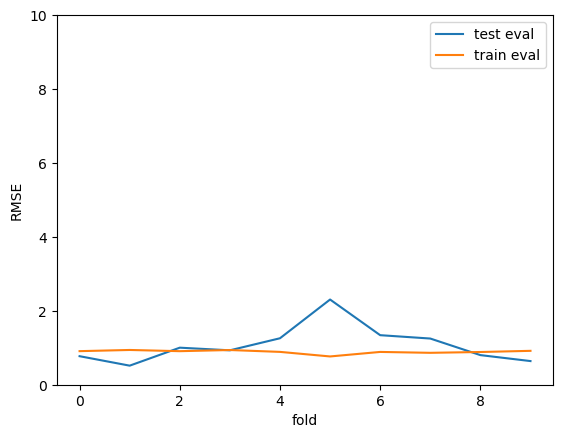

In [78]:
plt.plot(eval_rf['fold'], -1*eval_rf['test_rmse'], label = "test eval")
plt.plot(eval_rf['fold'], -1*eval_rf['train_rmse'], label = "train eval")
plt.xlabel("fold")
plt.ylabel("RMSE")
plt.legend()
plt.ylim(0,10)
plt.show()

In [79]:
rf_model = RandomForestRegressor(**{'bootstrap': True,
    'max_depth': 90,
    'max_features': 2,
    'min_samples_leaf': 4,
    'min_samples_split': 12,
    'n_estimators': 100})
rf_model.fit(X=training_data_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']], y=training_data_f['weighted_k'])

RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=4,
                      min_samples_split=12)

In [156]:
unknown.loc[:, 'weighted_k'] = rf_model.predict(unknown[['Luas', 'grid_pop', 'NDBI', 'NDVI']])

In [160]:
pd.concat([training_data, unknown]).to_csv('SVR.csv', index=False)

## Linier Regression

In [80]:
from sklearn.linear_model import LinearRegression, Ridge

In [87]:
skor_lr = cross_validate(LinearRegression(), 
                          X=training_data_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']], y=training_data_f['weighted_k'], 
                          scoring=('neg_mean_absolute_percentage_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_error','r2'),
                          cv=10, verbose=2, return_train_score=True)

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [88]:
eval_lr = pd.DataFrame.from_dict(skor_lr)
eval_lr['fold'] = np.arange(10)
eval_lr.columns = ['fit_time', 'score_time', 'test_mape', 'train_mape','test_rmse','train_rmse','test_mae','train_mae','test_r2','train_r2','fold']
eval_lr

,fit_time,score_time,test_mape,train_mape,test_rmse,train_rmse,test_mae,train_mae,test_r2,train_r2,fold
0,0.001269,0.002025,-1.085207e+14,-2.141182e+14,-1.611135,-1.455801,-1.316082,-0.992446,-3.135064,0.637505,0
1,0.004002,0.002000,-5.546480e+00,-2.429610e+14,-1.008067,-1.497835,-0.850505,-1.022771,0.609440,0.607060,1
2,0.002380,0.000998,-4.863450e+14,-2.048410e+14,-1.232043,-1.481237,-1.041197,-1.025607,0.180663,0.621148,2
3,0.002000,0.001999,-2.446566e+14,-2.102571e+14,-1.116004,-1.487532,-0.863609,-1.022006,0.624201,0.607538,3
4,0.002002,0.001000,-2.746188e+01,-2.167772e+14,-1.528420,-1.449517,-1.041236,-0.969901,0.721421,0.579024,4
5,0.001667,0.000982,-4.397414e+14,-2.068668e+14,-2.721188,-1.264044,-1.421880,-0.900786,0.514175,0.611649,5
6,0.001650,0.001001,-2.203018e+14,-1.964329e+14,-1.822069,-1.414456,-1.188249,-0.950600,0.557617,0.604211,6
7,0.001500,0.002084,-3.842285e+14,-2.067880e+14,-1.447678,-1.457075,-0.938396,-1.007895,0.632217,0.603113,7
8,0.002094,0.000500,-1.818112e+01,-2.395394e+14,-1.074719,-1.494142,-0.882149,-1.036538,0.227734,0.615526,8
9,0.001000,0.002000,-3.547132e+14,-1.932653e+14,-1.443559,-1.467659,-1.176391,-1.016558,-1.154023,0.626423,9


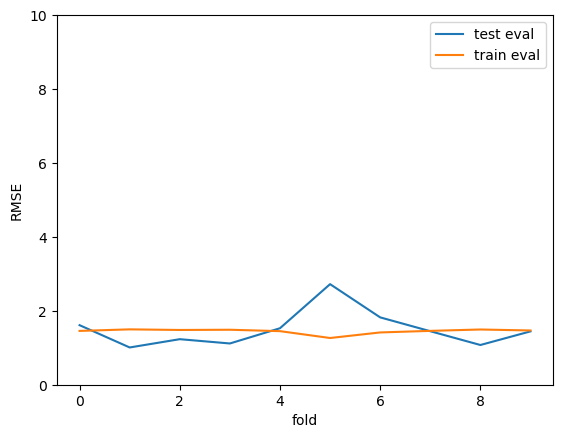

In [89]:
plt.plot(eval_lr['fold'], -1*eval_lr['test_rmse'], label = "test eval")
plt.plot(eval_lr['fold'], -1*eval_lr['train_rmse'], label = "train eval")
plt.xlabel("fold")
plt.ylabel("RMSE")
plt.legend()
plt.ylim(0,10)
plt.show()

## Ridge

In [90]:
# Create the parameter grid based on the results of random search 
ridge_param_grid = {
    'alpha': [0.1, 0.5, 5, 10]
}
# Create a based model
ridge = Ridge()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ridge, param_grid = ridge_param_grid, 
                          cv = 5, n_jobs = -1, verbose = 5)

In [92]:
grid_search.fit(X=training_data_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']],y=training_data_f['weighted_k'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 5, 10]}, verbose=5)

In [93]:
grid_search.best_params_

{'alpha': 10}

In [106]:
skor_ridge = cross_validate(Ridge(**grid_search.best_params_), 
                          X=training_data_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']], y=training_data_f['weighted_k'], 
                          scoring=('neg_mean_absolute_percentage_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_error','r2'),
                          cv=10, verbose=2, return_train_score=True)

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [107]:
eval_ridge = pd.DataFrame.from_dict(skor_ridge)
eval_ridge['fold'] = np.arange(10)
eval_ridge.columns = ['fit_time', 'score_time', 'test_mape', 'train_mape','test_rmse','train_rmse','test_mae','train_mae','test_r2','train_r2','fold']
eval_ridge

,fit_time,score_time,test_mape,train_mape,test_rmse,train_rmse,test_mae,train_mae,test_r2,train_r2,fold
0,0.003759,0.003005,-1.015070e+14,-2.033006e+14,-1.581851,-1.456906,-1.285655,-0.986404,-2.986112,0.636954,0
1,0.002000,0.003000,-5.388824e+00,-2.280446e+14,-1.001855,-1.498712,-0.837597,-1.015626,0.614238,0.606600,1
2,0.003002,0.001996,-4.588113e+14,-1.903118e+14,-1.208405,-1.482213,-1.017207,-1.017118,0.211801,0.620649,2
3,0.002520,0.002008,-2.262357e+14,-1.981248e+14,-1.109713,-1.488258,-0.851997,-1.014154,0.628426,0.607155,3
4,0.003000,0.002002,-2.647382e+01,-2.069743e+14,-1.551164,-1.450085,-1.051951,-0.962450,0.713069,0.578695,4
5,0.001999,0.001960,-4.083849e+14,-1.901809e+14,-2.729519,-1.265492,-1.423422,-0.893385,0.511196,0.610758,5
6,0.002002,0.002020,-2.037335e+14,-1.851398e+14,-1.835417,-1.415243,-1.205204,-0.942301,0.551111,0.603770,6
7,0.002003,0.001920,-3.518363e+14,-1.935095e+14,-1.449040,-1.457960,-0.925557,-1.000788,0.631524,0.602630,7
8,0.002002,0.001999,-1.679044e+01,-2.234320e+14,-1.048192,-1.494977,-0.862023,-1.028481,0.265387,0.615096,8
9,0.003032,0.002038,-3.322733e+14,-1.736915e+14,-1.389457,-1.469469,-1.140265,-1.009455,-0.995591,0.625501,9


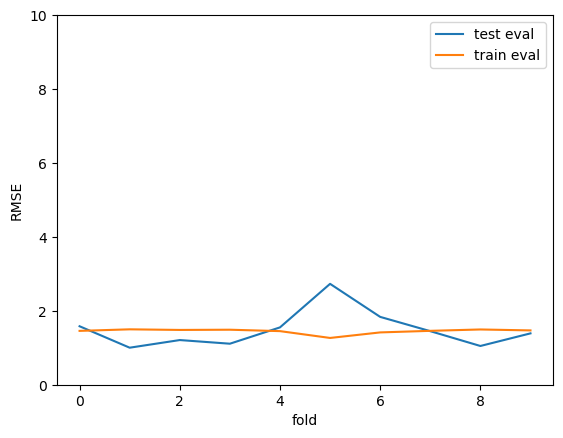

In [108]:
plt.plot(eval_ridge['fold'], -1*eval_ridge['test_rmse'], label = "test eval")
plt.plot(eval_ridge['fold'], -1*eval_ridge['train_rmse'], label = "train eval")
plt.xlabel("fold")
plt.ylabel("RMSE")
plt.legend()
plt.ylim(0,10)
plt.show()

## SVR

In [109]:
from sklearn.svm import SVR

In [111]:
skor_svr = cross_validate(SVR(C=0.1, gamma="auto"), 
                          X=training_data_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']], y=training_data_f['weighted_k'], 
                          scoring=('neg_mean_absolute_percentage_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_error','r2'),
                          cv=10, verbose=2, return_train_score=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [112]:
eval_svr = pd.DataFrame.from_dict(skor_svr)
eval_svr['fold'] = np.arange(10)
eval_svr.columns = ['fit_time', 'score_time', 'test_mape', 'train_mape','test_rmse','train_rmse','test_mae','train_mae','test_r2','train_r2','fold']
eval_svr

,fit_time,score_time,test_mape,train_mape,test_rmse,train_rmse,test_mae,train_mae,test_r2,train_r2,fold
0,0.008000,0.005100,-3.575178e+13,-8.490568e+13,-0.679580,-1.770600,-0.543838,-0.846746,0.264302,0.463785,0
1,0.014824,0.005320,-6.990471e-01,-7.571076e+13,-1.090581,-1.786036,-0.566230,-0.844136,0.542886,0.441299,1
2,0.008999,0.004141,-1.940173e+14,-7.199133e+13,-0.835945,-1.787592,-0.577371,-0.837129,0.622805,0.448231,2
3,0.005942,0.003102,-6.820615e+13,-7.564007e+13,-1.251638,-1.747852,-0.649181,-0.822904,0.527305,0.458156,3
4,0.005563,0.003000,-1.659550e+00,-8.050375e+13,-2.379507,-1.742153,-1.353631,-0.796207,0.324794,0.391889,4
5,0.004996,0.002012,-1.652333e+14,-7.651032e+13,-3.699179,-1.494953,-1.887172,-0.746815,0.102213,0.456806,5
6,0.009000,0.004000,-7.566734e+13,-8.013903e+13,-2.416409,-1.693963,-1.397841,-0.775588,0.221945,0.432334,6
7,0.005998,0.002014,-1.335257e+14,-8.585861e+13,-1.841102,-1.756177,-1.023003,-0.811084,0.405155,0.423446,7
8,0.004984,0.002004,-2.831472e+00,-8.493288e+13,-0.743718,-1.790458,-0.479035,-0.855080,0.630177,0.447908,8
9,0.006999,0.002001,-2.282722e+14,-7.969838e+13,-0.747705,-1.760734,-0.513414,-0.856113,0.422114,0.462328,9


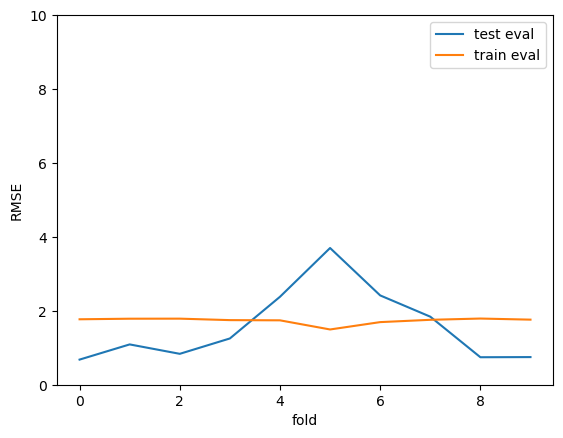

In [113]:
plt.plot(eval_svr['fold'], -1*eval_svr['test_rmse'], label = "test eval")
plt.plot(eval_svr['fold'], -1*eval_svr['train_rmse'], label = "train eval")
plt.xlabel("fold")
plt.ylabel("RMSE")
plt.legend()
plt.ylim(0,10)
plt.show()

## Regression Krigings

In [179]:
training_data_f.loc[:,'x'] = training_data_f.centroid.x
training_data_f.loc[:,'y'] = training_data_f.centroid.y

In [198]:
from pykrige.rk import RegressionKriging

svr_model = SVR(C=0.1, gamma="auto")
rf_model = RandomForestRegressor(**{'bootstrap': True,
    'max_depth': 90,
    'max_features': 2,
    'min_samples_leaf': 4,
    'min_samples_split': 12,
    'n_estimators': 100})
lr_model = LinearRegression()
ridge_model = Ridge(alpha=10)

models = [svr_model, rf_model, lr_model, ridge_model]

p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
    training_data_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']].values, training_data_f[['x','y']].values, training_data_f.weighted_k.values, test_size=0.3, random_state=42
)

for m in models:
    print("=" * 40)
    print("regression model:", m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=3)
    m_rk.fit(p_train, x_train, target_train)
    print("Regression Score: ", m_rk.regression_model.score(p_test, target_test))
    print("RK score: ", m_rk.score(p_test, x_test, target_test))

regression model: SVR
Finished learning regression model
Finished kriging residuals
Regression Score:  0.39592300111953294
RK score:  0.31782608723006966
regression model: RandomForestRegressor
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7959291172062926
RK score:  0.7941281037099732
regression model: LinearRegression
Finished learning regression model
Finished kriging residuals
Regression Score:  0.6260565424030904
RK score:  0.5516704200039897
regression model: Ridge
Finished learning regression model
Finished kriging residuals
Regression Score:  0.6285062480649656
RK score:  0.548585159501998


# Modeling dropped data

In [192]:
unknown_d = sample_drop[sample_drop.jmlkasus==0]
training_data_d = sample_drop[sample_drop.jmlkasus!=0]
training_data_d = training_data_d[['id', 'iddesa', 'centroid', 'Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO', 'weighted_k']]
unknown_d = unknown_d[['id', 'iddesa', 'centroid', 'Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']]

In [117]:
training_data_d

,id,iddesa,Luas,grid_pop,NDBI,NDVI,LST,CO,weighted_k
0,6,3276011006,1.130821,0.192314,0.318040,-0.308387,-0.320591,0.953753,0.712565
1,7,3276011006,1.037634,-0.007994,0.051829,-0.018343,-1.367000,0.922475,0.550910
2,8,3276011005,0.176845,-0.226480,-1.848519,1.963530,-1.718722,0.928508,0.662981
3,8,3276011006,-1.047273,-1.036393,-1.848519,1.963530,-1.718722,0.928508,0.096099
5,23,3276011006,1.045990,0.900198,0.431378,-0.032121,0.733456,1.715412,1.556288
...,...,...,...,...,...,...,...,...,...
578,367,3276041004,1.513845,0.327673,-1.703774,1.577051,-1.590383,-0.081421,1.003678
579,368,3276041004,1.518153,-0.136906,-2.526577,2.231322,-2.101396,-0.081421,0.552347
581,383,3276041004,-1.301697,-1.764758,-0.650627,0.062065,-0.549478,-0.106706,0.013165
582,384,3276041004,-0.474415,-1.054818,-1.703774,1.577051,-1.590383,-0.081421,0.110317


## Random Forest

In [118]:
# Create the parameter grid based on the results of random search 
rf_param_grid_d = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf_d = RandomForestRegressor()
# Instantiate the grid search model
rf_grid_search_d = GridSearchCV(estimator = rf_d, param_grid = rf_param_grid_d, 
                          cv = 5, n_jobs = -1, verbose = 5)

In [119]:
rf_grid_search_d.fit(X=training_data_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']],y=training_data_d['weighted_k'])

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=5)

In [122]:
rf_grid_search_d.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 200}

In [123]:
skor_rf_d = cross_validate(RandomForestRegressor(**rf_grid_search_d.best_params_), 
                          X=training_data_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']], y=training_data_f['weighted_k'], 
                          scoring=('neg_mean_absolute_percentage_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_error','r2'),
                          cv=10, verbose=2, return_train_score=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished


In [124]:
skor_rf_d

{'fit_time': array([0.25306249, 0.21642542, 0.26204515, 0.22355771, 0.20781541,
        0.27350116, 0.3089602 , 0.28246045, 0.28236151, 0.21955276]),
 'score_time': array([0.01440358, 0.0141139 , 0.02231359, 0.01207924, 0.01217604,
        0.01100087, 0.02309442, 0.02099919, 0.01075602, 0.01391649]),
 'test_neg_mean_absolute_percentage_error': array([-1.84267639e+12, -8.50738080e-01, -1.21985757e+14, -5.07851131e+12,
        -9.30443221e-01, -8.03058842e+13, -3.23482410e+12, -6.74887334e+12,
        -3.48451037e+00, -4.23049494e+13]),
 'train_neg_mean_absolute_percentage_error': array([-2.04183513e+13, -2.09453462e+13, -1.30571653e+13, -2.08654126e+13,
        -2.03052079e+13, -1.64723329e+13, -1.90027013e+13, -2.12866810e+13,
        -2.17933513e+13, -1.72439242e+13]),
 'test_neg_root_mean_squared_error': array([-0.78047916, -0.54288887, -0.9956202 , -0.95486308, -1.27105284,
        -2.18603444, -1.3904129 , -1.27040429, -0.745866  , -0.63362521]),
 'train_neg_root_mean_squared_error

In [125]:
eval_rf_d = pd.DataFrame.from_dict(skor_rf_d)
eval_rf_d['fold'] = np.arange(10)
eval_rf_d.columns = ['fit_time', 'score_time', 'test_mape', 'train_mape','test_rmse','train_rmse','test_mae','train_mae','test_r2','train_r2','fold']

In [126]:
eval_rf_d

,fit_time,score_time,test_mape,train_mape,test_rmse,train_rmse,test_mae,train_mae,test_r2,train_r2,fold
0,0.253062,0.014404,-1.842676e+12,-2.041835e+13,-0.780479,-0.924305,-0.554201,-0.477186,0.029622,0.853874,0
1,0.216425,0.014114,-8.507381e-01,-2.094535e+13,-0.542889,-0.920763,-0.358982,-0.476089,0.886726,0.851511,1
2,0.262045,0.022314,-1.219858e+14,-1.305717e+13,-0.995620,-0.900714,-0.655914,-0.459353,0.464945,0.859914,2
3,0.223558,0.012079,-5.078511e+12,-2.086541e+13,-0.954863,-0.909237,-0.546011,-0.465420,0.724890,0.853371,3
4,0.207815,0.012176,-9.304432e-01,-2.030521e+13,-1.271053,-0.903644,-0.781807,-0.438115,0.807341,0.836392,4
5,0.273501,0.011001,-8.030588e+13,-1.647233e+13,-2.186034,-0.742639,-0.985360,-0.431763,0.686472,0.865954,5
6,0.308960,0.023094,-3.234824e+12,-1.900270e+13,-1.390413,-0.875535,-0.773929,-0.443804,0.742394,0.848354,6
7,0.282460,0.020999,-6.748873e+12,-2.128668e+13,-1.270404,-0.877228,-0.846540,-0.432278,0.716775,0.856144,7
8,0.282362,0.010756,-3.484510e+00,-2.179335e+13,-0.745866,-0.903583,-0.511959,-0.462389,0.628038,0.859389,8
9,0.219553,0.013916,-4.230495e+13,-1.724392e+13,-0.633625,-0.926734,-0.398490,-0.482201,0.585002,0.851050,9


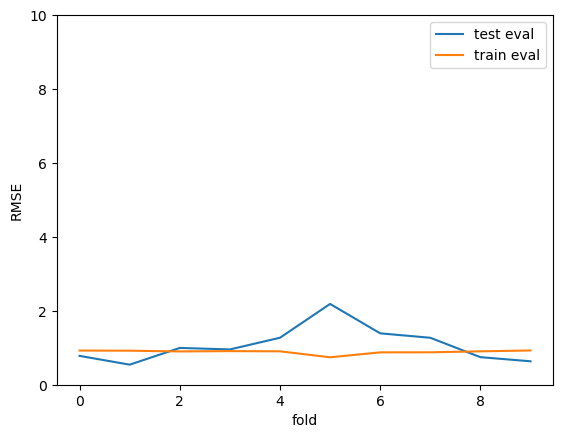

In [129]:
plt.plot(eval_rf_d['fold'], -1*eval_rf_d['test_rmse'], label = "test eval")
plt.plot(eval_rf_d['fold'], -1*eval_rf_d['train_rmse'], label = "train eval")
plt.xlabel("fold")
plt.ylabel("RMSE")
plt.legend()
plt.ylim(0,10)
plt.show()

In [79]:
rf_model = RandomForestRegressor(**rf_grid_search.best_params_)
rf_model.fit(X=training_data_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']], y=training_data_f['weighted_k'])

RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=4,
                      min_samples_split=12)

In [156]:
unknown.loc[:, 'weighted_k'] = rf_model.predict(unknown[['Luas', 'grid_pop', 'NDBI', 'NDVI']])

In [160]:
pd.concat([training_data, unknown]).to_csv('SVR.csv', index=False)

## Linier Regression

In [133]:
skor_lr_d = cross_validate(LinearRegression(), 
                          X=training_data_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']], y=training_data_d['weighted_k'], 
                          scoring=('neg_mean_absolute_percentage_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_error','r2'),
                          cv=10, verbose=2, return_train_score=True)

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [134]:
eval_lr_d = pd.DataFrame.from_dict(skor_lr_d)
eval_lr_d['fold'] = np.arange(10)
eval_lr_d.columns = ['fit_time', 'score_time', 'test_mape', 'train_mape','test_rmse','train_rmse','test_mae','train_mae','test_r2','train_r2','fold']
eval_lr_d

,fit_time,score_time,test_mape,train_mape,test_rmse,train_rmse,test_mae,train_mae,test_r2,train_r2,fold
0,0.003013,0.002363,-10.947742,-11.319981,-1.563240,-1.486907,-1.305276,-1.009723,-3.173013,0.631889,0
1,0.003508,0.003000,-4.102774,-12.038178,-0.986137,-1.527569,-0.844553,-1.048331,0.454680,0.609446,1
2,0.004000,0.002107,-26.480644,-10.202428,-1.320806,-1.499571,-1.146847,-1.029903,0.359338,0.619764,2
3,0.003000,0.001540,-7.876409,-11.924783,-1.175422,-1.511075,-0.903194,-1.042040,0.564380,0.611122,3
4,0.001526,0.001002,-1.753147,-11.046883,-1.507464,-1.480598,-1.023352,-0.992448,0.731371,0.576036,4
5,0.001000,0.002156,-1.000433,-10.550980,-2.819832,-1.276898,-1.427229,-0.919457,0.493064,0.614732,5
6,0.001503,0.001000,-0.971175,-11.457293,-1.846247,-1.441238,-1.196286,-0.966802,0.552290,0.603233,6
7,0.003079,0.001104,-1.873933,-12.208531,-1.490708,-1.480160,-0.969177,-1.023781,0.598970,0.605890,7
8,0.002000,0.001926,-15.906220,-12.064269,-1.114024,-1.518985,-0.906502,-1.054539,0.188211,0.614904,8
9,0.001999,0.002000,-54.162407,-9.200504,-1.530668,-1.487290,-1.254045,-1.026773,-1.273540,0.628599,9


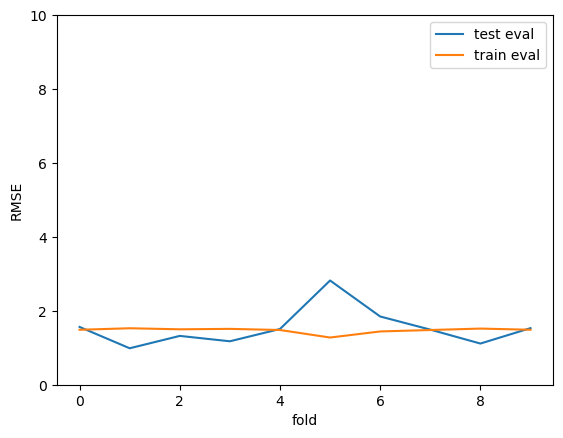

In [135]:
plt.plot(eval_lr_d['fold'], -1*eval_lr_d['test_rmse'], label = "test eval")
plt.plot(eval_lr_d['fold'], -1*eval_lr_d['train_rmse'], label = "train eval")
plt.xlabel("fold")
plt.ylabel("RMSE")
plt.legend()
plt.ylim(0,10)
plt.show()

## Ridge

In [136]:
# Create the parameter grid based on the results of random search 
ridge_param_grid_d = {
    'alpha': [0.1, 0.5, 5, 10]
}
# Create a based model
ridge_d = Ridge()
# Instantiate the grid search model
grid_search_d = GridSearchCV(estimator = ridge_d, param_grid = ridge_param_grid_d, 
                          cv = 5, n_jobs = -1, verbose = 5)

In [137]:
grid_search_d.fit(X=training_data_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']],y=training_data_d['weighted_k'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 5, 10]}, verbose=5)

In [138]:
grid_search_d.best_params_

{'alpha': 10}

In [146]:
skor_ridge_d = cross_validate(Ridge(**grid_search_d.best_params_), 
                          X=training_data_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']], y=training_data_d['weighted_k'], 
                          scoring=('neg_mean_absolute_percentage_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_error','r2'),
                          cv=10, verbose=2, return_train_score=True)

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [147]:
eval_ridge_d = pd.DataFrame.from_dict(skor_ridge_d)
eval_ridge_d['fold'] = np.arange(10)
eval_ridge_d.columns = ['fit_time', 'score_time', 'test_mape', 'train_mape','test_rmse','train_rmse','test_mae','train_mae','test_r2','train_r2','fold']
eval_ridge_d

,fit_time,score_time,test_mape,train_mape,test_rmse,train_rmse,test_mae,train_mae,test_r2,train_r2,fold
0,0.002459,0.001510,-10.684903,-10.526495,-1.555678,-1.488974,-1.284529,-1.001727,-3.132737,0.630865,0
1,0.002000,0.001000,-3.972022,-11.177682,-0.964528,-1.530312,-0.815282,-1.037544,0.478316,0.608042,1
2,0.003000,0.002000,-24.358721,-9.463784,-1.282878,-1.502385,-1.111975,-1.017142,0.395603,0.618336,2
3,0.002000,0.002000,-7.309957,-11.125097,-1.167492,-1.513071,-0.884593,-1.031189,0.570238,0.610094,3
4,0.002000,0.002001,-1.653544,-10.254523,-1.545167,-1.482524,-1.036888,-0.983105,0.717766,0.574932,4
5,0.001867,0.001998,-1.000114,-9.632718,-2.823454,-1.280514,-1.435583,-0.906317,0.491761,0.612547,5
6,0.001000,0.002000,-0.884936,-10.633253,-1.867546,-1.443183,-1.215550,-0.957126,0.541901,0.602161,6
7,0.003007,0.002000,-1.589080,-11.343650,-1.491540,-1.482460,-0.946998,-1.014828,0.598522,0.604664,7
8,0.002000,0.002001,-13.529358,-11.190428,-1.042963,-1.522150,-0.853891,-1.044025,0.288473,0.613298,8
9,0.002000,0.003000,-50.499112,-8.509011,-1.478454,-1.490419,-1.209947,-1.016357,-1.121077,0.627035,9


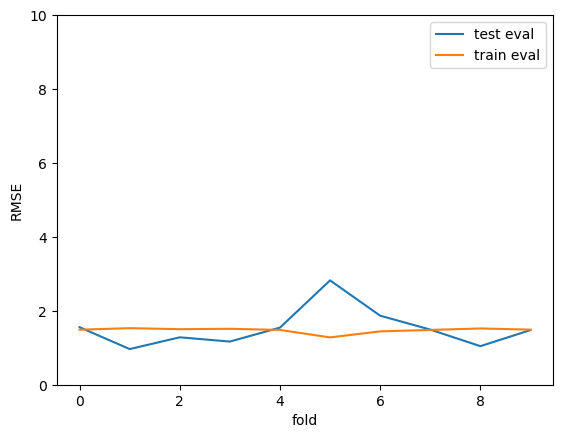

In [148]:
plt.plot(eval_ridge_d['fold'], -1*eval_ridge_d['test_rmse'], label = "test eval")
plt.plot(eval_ridge_d['fold'], -1*eval_ridge_d['train_rmse'], label = "train eval")
plt.xlabel("fold")
plt.ylabel("RMSE")
plt.legend()
plt.ylim(0,10)
plt.show()

## SVR

In [149]:
skor_svr_d = cross_validate(SVR(C=0.1, gamma="auto"), 
                          X=training_data_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']], y=training_data_d['weighted_k'], 
                          scoring=('neg_mean_absolute_percentage_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_error','r2'),
                          cv=10, verbose=2, return_train_score=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [150]:
eval_svr_d = pd.DataFrame.from_dict(skor_svr_d)
eval_svr_d['fold'] = np.arange(10)
eval_svr_d.columns = ['fit_time', 'score_time', 'test_mape', 'train_mape','test_rmse','train_rmse','test_mae','train_mae','test_r2','train_r2','fold']
eval_svr_d

,fit_time,score_time,test_mape,train_mape,test_rmse,train_rmse,test_mae,train_mae,test_r2,train_r2,fold
0,0.006188,0.003812,-3.868630,-1.543676,-0.695665,-1.837662,-0.565850,-0.892967,0.173584,0.437733,0
1,0.004999,0.003000,-0.782217,-1.459445,-0.855576,-1.851644,-0.456856,-0.901068,0.589517,0.426155,1
2,0.005343,0.003186,-2.597535,-1.271860,-1.131755,-1.859630,-0.718665,-0.877965,0.529612,0.415247,2
3,0.008432,0.004095,-0.650197,-1.524537,-1.285673,-1.813342,-0.672492,-0.867204,0.478828,0.439984,3
4,0.005000,0.002000,-0.750105,-1.361768,-2.478338,-1.811117,-1.474536,-0.839236,0.273928,0.365621,4
5,0.006002,0.002999,-0.589564,-1.291386,-3.854506,-1.547255,-2.011523,-0.782944,0.052795,0.434317,5
6,0.007444,0.004172,-0.682256,-1.455063,-2.516872,-1.756923,-1.504413,-0.815669,0.167970,0.410383,6
7,0.008216,0.004075,-0.591435,-1.364773,-1.922684,-1.825147,-1.086593,-0.854884,0.332874,0.400766,7
8,0.006523,0.003005,-2.211029,-1.477859,-0.776092,-1.859403,-0.510487,-0.898370,0.606015,0.422956,8
9,0.004930,0.002076,-9.713563,-1.497343,-0.752516,-1.821486,-0.511660,-0.896397,0.450494,0.442938,9


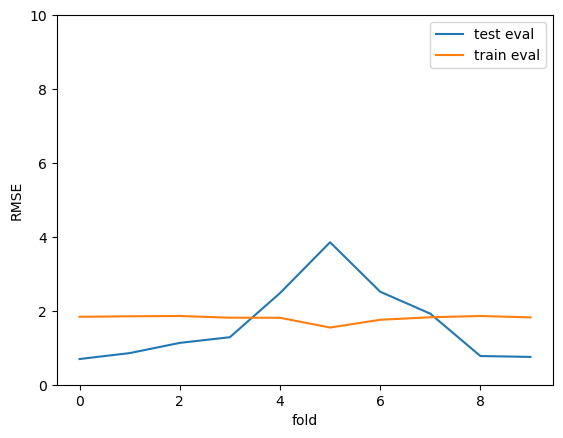

In [152]:
plt.plot(eval_svr_d['fold'], -1*eval_svr_d['test_rmse'], label = "test eval")
plt.plot(eval_svr_d['fold'], -1*eval_svr_d['train_rmse'], label = "train eval")
plt.xlabel("fold")
plt.ylabel("RMSE")
plt.legend()
plt.ylim(0,10)
plt.show()

# Spatial Regression

In [193]:
training_data_d.loc[:,'x'] = training_data_d.centroid.x
training_data_d.loc[:,'y'] = training_data_d.centroid.y

In [196]:
from pykrige.rk import RegressionKriging
from sklearn.model_selection import train_test_split

svr_model = SVR(C=0.1, gamma="auto")
rf_model = RandomForestRegressor(**{'bootstrap': True,
    'max_depth': 80,
    'max_features': 2,
    'min_samples_leaf': 5,
    'min_samples_split': 10,
    'n_estimators': 200})
lr_model = LinearRegression()
ridge_model = Ridge(alpha=10)

models = [svr_model, rf_model, lr_model, ridge_model]

p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
    training_data_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']].values, training_data_d[['x','y']].values, training_data_d.weighted_k.values, test_size=0.3, random_state=42
)

for m in models:
    print("=" * 40)
    print("regression model:", m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=3)
    m_rk.fit(p_train, x_train, target_train)
    print("Regression Score: ", m_rk.regression_model.score(p_test, target_test))
    print("RK score: ", m_rk.score(p_test, x_test, target_test))

regression model: SVR
Finished learning regression model
Finished kriging residuals
Regression Score:  0.30231660461305554
RK score:  0.16771697070242642
regression model: RandomForestRegressor
Finished learning regression model
Finished kriging residuals
Regression Score:  0.6721574197567572
RK score:  0.659308236341307
regression model: LinearRegression
Finished learning regression model
Finished kriging residuals
Regression Score:  0.5295102643573708
RK score:  0.4967570445404167
regression model: Ridge
Finished learning regression model
Finished kriging residuals
Regression Score:  0.5238560094322409
RK score:  0.48080218471593794


# Estimasi Menggunakan Model

In [210]:
rf_model_f = RandomForestRegressor(**{'bootstrap': True,
    'max_depth': 90,
    'max_features': 2,
    'min_samples_leaf': 4,
    'min_samples_split': 12,
    'n_estimators': 100})
lr_model_f = LinearRegression()
ridge_model_f = Ridge(alpha=10)
svr_model_f = SVR(C=0.1, gamma="auto")

r_rf_model_f = RegressionKriging(regression_model=RandomForestRegressor(**{'bootstrap': True,
    'max_depth': 90,
    'max_features': 2,
    'min_samples_leaf': 4,
    'min_samples_split': 12,
    'n_estimators': 100}), n_closest_points=3)
r_lr_model_f = RegressionKriging(regression_model=LinearRegression(), n_closest_points=3)
r_ridge_model_f = RegressionKriging(regression_model=Ridge(alpha=10), n_closest_points=3)
r_svr_model_f = RegressionKriging(regression_model=SVR(C=0.1, gamma="auto"), n_closest_points=3)

In [212]:
r_models_f = [rf_model_f, lr_model_f, ridge_model_f, svr_model_f]
sr_models_f = [r_rf_model_f, r_lr_model_f, r_ridge_model_f, r_svr_model_f]

for m in r_models_f:
    m.fit(X=training_data_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']], y=training_data_f['weighted_k'])
for m in sr_models_f:
    m.fit(training_data_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']].values, training_data_f[['x','y']].values, training_data_f.weighted_k.values)

Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals


In [222]:
unknown_f.loc[:, 'x'] = unknown_f.centroid.x
unknown_f.loc[:, 'y'] = unknown_f.centroid.y

In [226]:
unknown_f.loc[:, 'rf_fill'] = rf_model_f.predict(unknown_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']])
unknown_f.loc[:, 'lr_fill'] = lr_model_f.predict(unknown_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']])
unknown_f.loc[:, 'ridge_fill'] = ridge_model_f.predict(unknown_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']])
unknown_f.loc[:, 'svr_fill'] = svr_model_f.predict(unknown_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']])

unknown_f.loc[:, 'sr_rf_fill'] = r_rf_model_f.predict(p=unknown_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']].values, x=unknown_f[['x','y']].values)
unknown_f.loc[:, 'sr_lr_fill'] = r_lr_model_f.predict(p=unknown_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']].values, x=unknown_f[['x','y']].values)
unknown_f.loc[:, 'sr_ridge_fill'] = r_ridge_model_f.predict(p=unknown_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']].values, x=unknown_f[['x','y']].values)
unknown_f.loc[:, 'sr_svr_fill'] = r_svr_model_f.predict(p=unknown_f[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']].values, x=unknown_f[['x','y']].values)

# ---------------------------------------------------------------------------------------------------------------

In [208]:
svr_model_d = SVR(C=0.1, gamma="auto")
rf_model_d = RandomForestRegressor(**{'bootstrap': True,
    'max_depth': 80,
    'max_features': 2,
    'min_samples_leaf': 5,
    'min_samples_split': 10,
    'n_estimators': 200})
lr_model_d = LinearRegression()
ridge_model_d = Ridge(alpha=10)

r_rf_model_d = RegressionKriging(regression_model=RandomForestRegressor(**{'bootstrap': True,
    'max_depth': 80,
    'max_features': 2,
    'min_samples_leaf': 5,
    'min_samples_split': 10,
    'n_estimators': 200}), n_closest_points=3)
r_lr_model_d = RegressionKriging(regression_model=LinearRegression(), n_closest_points=3)
r_ridge_model_d = RegressionKriging(regression_model=Ridge(alpha=10), n_closest_points=3)
r_svr_model_d = RegressionKriging(regression_model=SVR(C=0.1, gamma="auto"), n_closest_points=3)

In [214]:
r_models_d = [rf_model_d, lr_model_d, ridge_model_d, svr_model_d]
sr_models_d = [r_rf_model_d, r_lr_model_d, r_ridge_model_d, r_svr_model_d]

for m in r_models_d:
    m.fit(X=training_data_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']], y=training_data_d['weighted_k'])
for m in sr_models_d:
    m.fit(training_data_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']].values, training_data_d[['x','y']].values, training_data_d.weighted_k.values)

Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals


In [228]:
unknown_d.loc[:, 'x'] = unknown_d.centroid.x
unknown_d.loc[:, 'y'] = unknown_d.centroid.y

In [229]:
unknown_d.loc[:, 'rf_drop'] = rf_model_d.predict(unknown_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']])
unknown_d.loc[:, 'lr_drop'] = lr_model_d.predict(unknown_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']])
unknown_d.loc[:, 'ridge_drop'] = ridge_model_d.predict(unknown_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']])
unknown_d.loc[:, 'svr_drop'] = svr_model_d.predict(unknown_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']])

unknown_d.loc[:, 'sr_rf_drop'] = r_rf_model_d.predict(p=unknown_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']].values, x=unknown_d[['x','y']].values)
unknown_d.loc[:, 'sr_lr_drop'] = r_lr_model_d.predict(p=unknown_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']].values, x=unknown_d[['x','y']].values)
unknown_d.loc[:, 'sr_ridge_drop'] = r_ridge_model_d.predict(p=unknown_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']].values, x=unknown_d[['x','y']].values)
unknown_d.loc[:, 'sr_svr_drop'] = r_svr_model_d.predict(p=unknown_d[['Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST', 'CO']].values, x=unknown_d[['x','y']].values)

In [231]:
unknown_f.columns

Index(['id', 'iddesa', 'centroid', 'Luas', 'grid_pop', 'NDBI', 'NDVI', 'LST',
       'CO', 'x', 'y', 'rf_fill', 'lr_fill', 'ridge_fill', 'svr_fill',
       'sr_rf_fill', 'sr_lr_fill', 'sr_ridge_fill', 'sr_svr_fill'],
      dtype='object')

In [235]:
unknown_all = unknown_f[['id', 'iddesa', 'rf_fill', 'lr_fill', 'ridge_fill', 'svr_fill', 'sr_rf_fill', 'sr_lr_fill', 'sr_ridge_fill', 'sr_svr_fill']].merge(unknown_d[['id', 'iddesa', 'rf_drop', 'lr_drop', 'ridge_drop', 'svr_drop', 'sr_rf_drop', 'sr_lr_drop', 'sr_ridge_drop', 'sr_svr_drop']], on=['id', 'iddesa'], how='left')
unknown_all = unknown_all.fillna(0)

In [238]:
unknown_all.to_csv('prediction.csv', index=False)

In [295]:
sa = grid_intersec[['id', 'iddesa', 'nmprov', 'nmkab', 'nmkec', 'nmdesa', 'geometry']].merge(sample[['id', 'iddesa', 'weighted_k', 'SAMPLE_1', 'SAMPLE_1_2', 'new_id', 'jmlkasus', 'NDBI', 'NDVI', 'CO', 'LST', 'grid_pop', 'Luas']], on=['id', 'iddesa'])

In [298]:
sa = sa.merge(unknown_all, on=['id', 'iddesa'], how='left')

In [300]:
sa.loc[sa.rf_drop.isna(), 'rf_drop'] = sa.loc[sa.rf_drop.isna(), 'weighted_k']
sa.loc[sa.lr_drop.isna(), 'lr_drop'] = sa.loc[sa.lr_drop.isna(), 'weighted_k']
sa.loc[sa.ridge_drop.isna(), 'ridge_drop'] = sa.loc[sa.ridge_drop.isna(), 'weighted_k']
sa.loc[sa.svr_drop.isna(), 'svr_drop'] = sa.loc[sa.svr_drop.isna(), 'weighted_k']
sa.loc[sa.sr_rf_drop.isna(), 'sr_rf_drop'] = sa.loc[sa.sr_rf_drop.isna(), 'weighted_k']
sa.loc[sa.sr_lr_drop.isna(), 'sr_lr_drop'] = sa.loc[sa.sr_lr_drop.isna(), 'weighted_k']
sa.loc[sa.sr_ridge_drop.isna(), 'sr_ridge_drop'] = sa.loc[sa.sr_ridge_drop.isna(), 'weighted_k']
sa.loc[sa.sr_svr_drop.isna(), 'sr_svr_drop'] = sa.loc[sa.sr_svr_drop.isna(), 'weighted_k']

sa.loc[sa.rf_fill.isna(), 'rf_fill'] = sa.loc[sa.rf_fill.isna(), 'weighted_k']
sa.loc[sa.lr_fill.isna(), 'lr_fill'] = sa.loc[sa.lr_fill.isna(), 'weighted_k']
sa.loc[sa.ridge_fill.isna(), 'ridge_fill'] = sa.loc[sa.ridge_fill.isna(), 'weighted_k']
sa.loc[sa.svr_fill.isna(), 'svr_fill'] = sa.loc[sa.svr_fill.isna(), 'weighted_k']
sa.loc[sa.sr_rf_fill.isna(), 'sr_rf_fill'] = sa.loc[sa.sr_rf_fill.isna(), 'weighted_k']
sa.loc[sa.sr_lr_fill.isna(), 'sr_lr_fill'] = sa.loc[sa.sr_lr_fill.isna(), 'weighted_k']
sa.loc[sa.sr_ridge_fill.isna(), 'sr_ridge_fill'] = sa.loc[sa.sr_ridge_fill.isna(), 'weighted_k']
sa.loc[sa.sr_svr_fill.isna(), 'sr_svr_fill'] = sa.loc[sa.sr_svr_fill.isna(), 'weighted_k']

In [302]:
sa.to_file('prediction_join.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_7896\2047119599.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sa.to_file('prediction_join.shp')


In [303]:
sa.drop(columns='geometry').to_csv('prediction_join.csv', index=False)

In [305]:
sa = sa.fillna(0)

C:\Users\User\AppData\Local\Temp\ipykernel_7896\1064939582.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)


[]

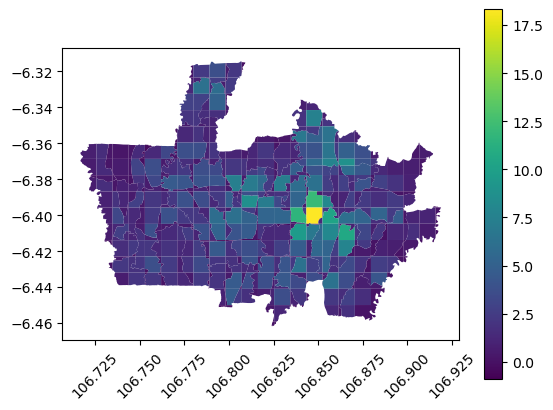

In [317]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
sa.plot(column='sr_rf_fill', ax=ax, legend=True)
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)
plt.plot()

In [313]:
columns = ['SAMPLE_1', 'SAMPLE_1_2', 'rf_drop', 'lr_drop', 'ridge_drop', 'svr_drop', 'sr_rf_drop', 'sr_lr_drop', 'sr_ridge_drop', 'sr_svr_drop', 'rf_fill', 'lr_fill', 'ridge_fill', 'svr_fill', 'sr_rf_fill', 'sr_lr_fill', 'sr_ridge_fill', 'sr_svr_fill']

In [319]:
sa[columns].describe()

,SAMPLE_1,SAMPLE_1_2,rf_drop,lr_drop,ridge_drop,svr_drop,sr_rf_drop,sr_lr_drop,sr_ridge_drop,sr_svr_drop,rf_fill,lr_fill,ridge_fill,svr_fill,sr_rf_fill,sr_lr_fill,sr_ridge_fill,sr_svr_fill
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,1.172074,1.541099,1.716639,1.740581,1.730456,1.541532,1.685711,1.566722,1.570044,1.556654,1.713781,1.728804,1.723932,1.533314,1.669740,1.566085,1.565254,1.568518
std,1.641944,0.926063,2.094003,2.134692,2.122226,1.931116,2.090514,2.148699,2.136956,1.942330,2.087633,2.119296,2.109434,1.931768,2.095077,2.157458,2.147574,1.944213
min,-2.847114,0.177682,0.000000,-2.316099,-2.289026,-0.014862,-0.610241,-3.192240,-3.063880,-0.624132,0.000000,-2.335879,-2.284080,-0.041100,-0.881144,-2.898778,-2.830381,-0.806943
25%,-0.033120,0.884418,0.243086,0.207274,0.200061,0.254382,0.231080,0.122131,0.124546,0.248629,0.246824,0.238398,0.241420,0.270089,0.225613,0.167665,0.185722,0.315034
50%,0.832027,1.274123,0.993260,1.180588,1.176281,0.990120,1.032386,1.046822,1.046822,1.065030,1.016984,1.162120,1.145847,0.965004,1.017686,1.059893,1.057319,1.054173
75%,2.046516,2.033669,2.311483,2.728964,2.722646,2.086331,2.307228,2.434710,2.412331,2.119728,2.271383,2.728194,2.711458,2.097638,2.273393,2.461271,2.421644,2.121982
max,5.654866,5.389622,18.326291,18.326291,18.326291,18.326291,18.326291,18.326291,18.326291,18.326291,18.326291,18.326291,18.326291,18.326291,18.326291,18.326291,18.326291,18.326291
